In [35]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost 
import mplhep as hep
hep.style.use('LHCb1')

In [36]:
def IV_Analyser(filepath):
    '''
    
    :param file: Name of the Input file 
    :return: array_like:    V_mean: array of mean voltage values at the K2600
                            U_mean: array of mean voltage values at the K2000
                            DU: array of standard deviations of the voltages at the K2000
                            I_mean: array of mean currents at the K2600
                            DI: array of the standard deviations of the current at the K2600
    '''                     
    try:    
        _, _, n = np.loadtxt(filepath, unpack = True, dtype = 'object', max_rows = 1)
        n = float(n)
        n= int(n)
        V, I = np.loadtxt(filepath, skiprows = 2, unpack = True, usecols=[0, 1])
    except FileNotFoundError:
        print(filepath, 'File not found')
        return

    V_sliced = np.split(V, n)
    I_sliced = np.split(I, n)
    
    V_mean = np.mean(V_sliced, axis = 1)  
    I_mean = np.mean(I_sliced, axis = 1)*1e9
    DI = np.std(I_sliced, axis = 1)*1e9
    return np.abs(V_mean), np.abs(I_mean), DI

def trapTunnelingFit(x, a, b, c, d, e):
    return a*np.sqrt(x)+b+np.heaviside(x-c, 0)*d*x*(np.exp(e*x))**2

In [44]:
U, I, DI = IV_Analyser('data/Backside.txt')
limits = [5, 190]
U_fit = U[limits[0]:limits[1]]
I_fit = I[limits[0]:limits[1]]
DI_fit = DI[limits[0]:limits[1]]

In [45]:
c = cost.LeastSquares(U_fit, I_fit, DI_fit, trapTunnelingFit)
c.loss = 'soft_l1'
m = Minuit(c, a = 4.5, b = -8, c = 60, d = 20e-3, e = 1e-3) 
m.limits['c'] = (20, 100)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 969.1 (χ²/ndof = 5.4)      │              Nfcn = 825              │
│ EDM = 1.22 (Goal: 0.0002)        │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   4.485   │   0.013   │            │            │         │         │       │
│ 1 │ b    │   -8.91   │   0.09    │            │            │         │         │       │
│ 2 │ c    │   58.72   │   0.04    │            │            │   20    │   100   │       │
│ 3 │ d    │  0.76e-3  │  0.05e-3  │            │            │         │         │       │
│ 4 │ e    │ 14.12e-3  │  0.16e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────────────────────────┐
│   │         a         b         c         d         e │
├───┼───────────────────────────────────────────────────┤
│ a │  0.000168  -1.04e-3  -0.24e-3 -320.5e-9  0.955e-6 │
│ b │  -1.04e-3   0.00727    0.0008 1.1107e-6 -2.819e-6 │
│ c │  -0.24e-3    0.0008   0.00134 1.6763e-6 -5.779e-6 │
│ d │ -320.5e-9 1.1107e-6 1.6763e-6  2.18e-09   -7.5e-9 │
│ e │  0.955e-6 -2.819e-6 -5.779e-6   -7.5e-9  2.61e-08 │
└───┴───────────────────────────────────────────────────┘

Text(0.5, 1.0, 'Backside Tunneling Fit')

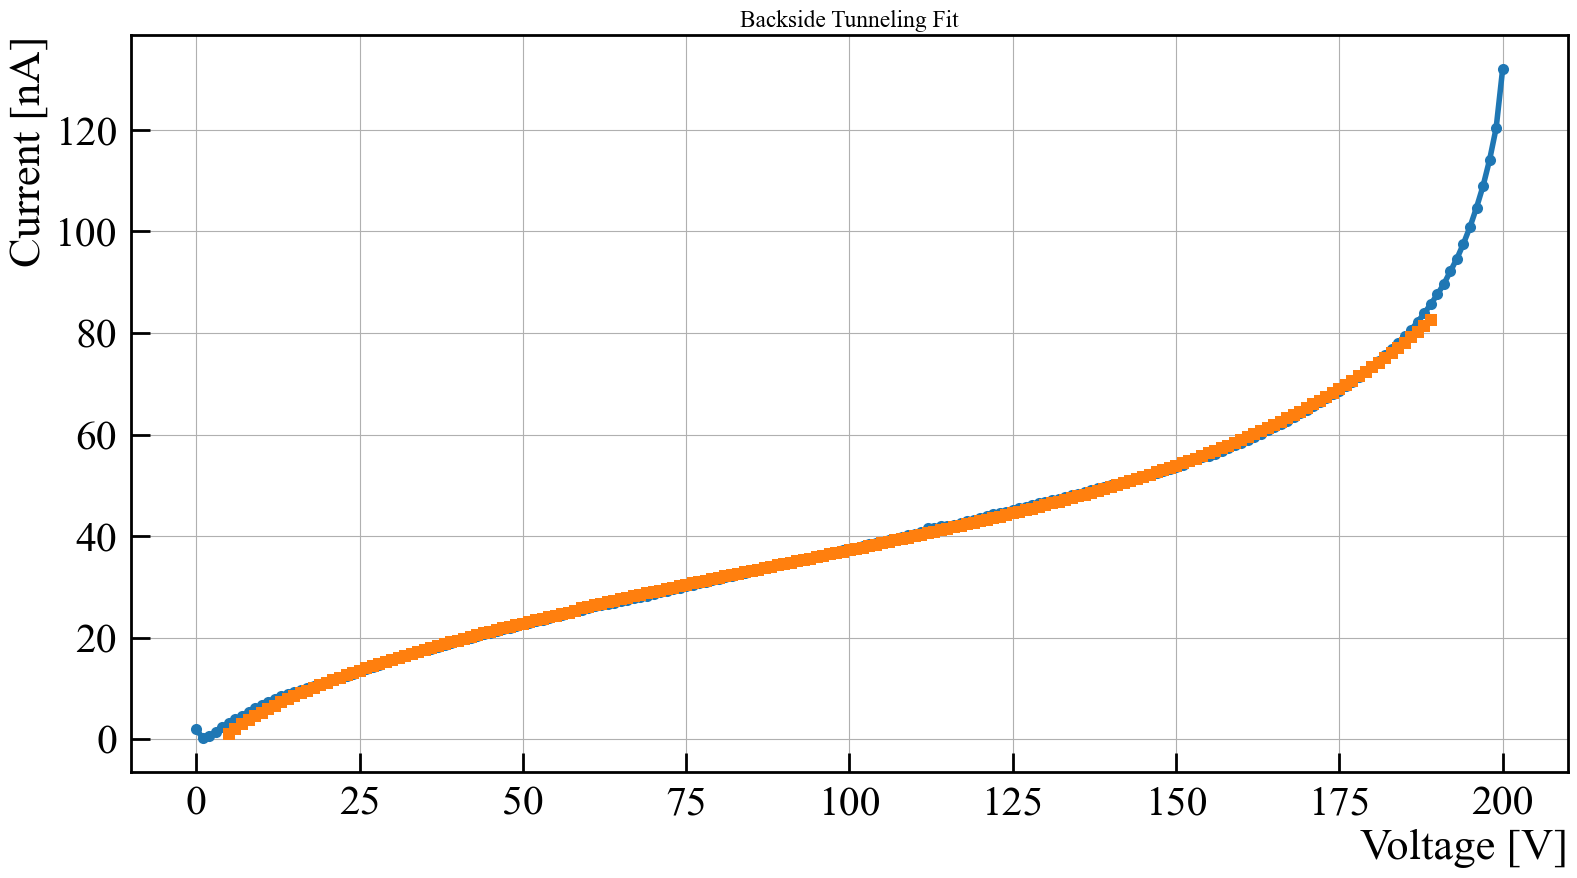

In [46]:
plt.figure(figsize=(16, 9))
plt.plot(U, I, label = 'Data')
plt.plot(U_fit, trapTunnelingFit(U_fit, *m.values), label = 'Fit')
plt.grid(True)
plt.xlabel('Voltage [V]')
plt.ylabel('Current [nA]')
plt.title('Backside Tunneling Fit')